# Data augmentation

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_09c import *

## 1. PIL transforms

We start with PIL transforms to resize all our images to the same size. Then, when they are in a batch, we can apply data augmentation to all of them at the same time on the GPU. We have already seen the basics of resizing and putting on the GPU in 08, but we'll look more into it now.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=6882)

### View Imagenette images

In [3]:
#export
make_rgb._order=0

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE)
# tfms version 1
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [5]:
def get_il(tfms): return ImageList.from_files(path, tfms=tfms)

In [6]:
il = get_il(tfms)

In [7]:
# generate a random image from imagenette
import random
#random_index = random.randint(1,len(il))
random_index = 8494

In [8]:
# random_index for truck is 8494
print(random_index)

8494


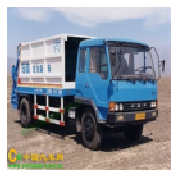

In [9]:
show_image(il[random_index])

In [10]:
img = PIL.Image.open(il.items[random_index])

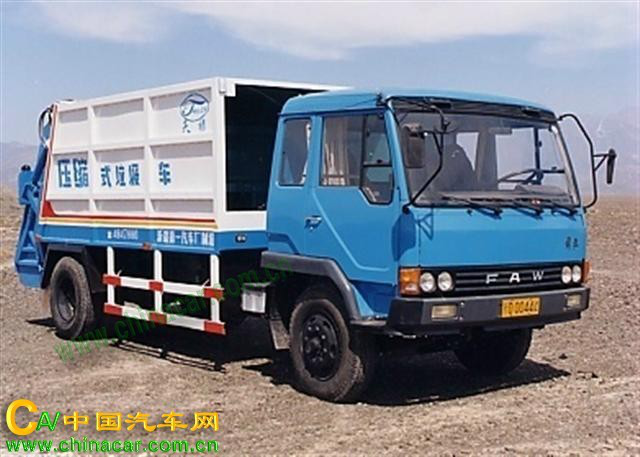

In [11]:
img

In [12]:
img.getpixel((1,1))

(197, 216, 248)

In [13]:
import numpy as np

In [14]:
%timeit -n 10 a = np.array(PIL.Image.open(il.items[random_index]))

3.91 ms ± 53.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Try some resampling methods. Be careful: you can quickly lose some textures!

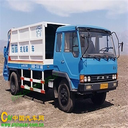

In [15]:
img.resize((128,128), resample=PIL.Image.ANTIALIAS)

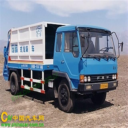

In [16]:
img.resize((128,128), resample=PIL.Image.BILINEAR)

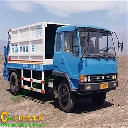

In [17]:
img.resize((128,128), resample=PIL.Image.NEAREST)

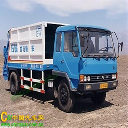

In [18]:
img.resize((256,256), resample=PIL.Image.BICUBIC).resize((128,128), resample=PIL.Image.NEAREST)

In [19]:
%timeit img.resize((224,224), resample=PIL.Image.BICUBIC)

1.81 ms ± 2.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
%timeit img.resize((224,224), resample=PIL.Image.BILINEAR)

1.14 ms ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [21]:
%timeit -n 10 img.resize((224,224), resample=PIL.Image.NEAREST)

38.4 µs ± 3.36 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 1A. Flip

Flip can be done with PIL very fast.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=7092)

In [22]:
#export
import random

In [23]:
def pil_random_flip(x):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<0.5 else x

In [24]:
# create a batch consisting of 64 copies of the same image
il1 = get_il(tfms)
il1.items = [il1.items[random_index]]*64
dl = DataLoader(il1, 8)

In [25]:
x = next(iter(dl))
print(x.size())

torch.Size([8, 3, 128, 128])


Here is a convenience function to look at images in a batch.

In [26]:
#export
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))

def show_batch(x, c=4, r=None, figsize=None):
    # number of images in the batch
    n = len(x)
    # set up the batch images display
    # r and c are number of rows and columns in the subplots
    # compute the number of rows if unspecified
    if r is None: r = int(math.ceil(n/c))
    # specify the layout of the subplots
    if figsize is None: figsize=(c*3,r*3)
    # create the subplots
    fig,axes = plt.subplots(r,c, figsize=figsize)
    # populate the subplots
    for xi,ax in zip(x,axes.flat): show_image(xi, ax)

Without data augmentation:

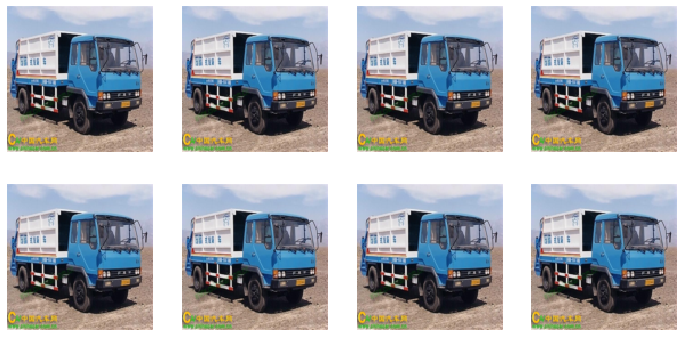

In [27]:
show_batch(x)

With random flip:

In [28]:
il1.tfms.append(pil_random_flip)

torch.Size([8, 3, 128, 128])


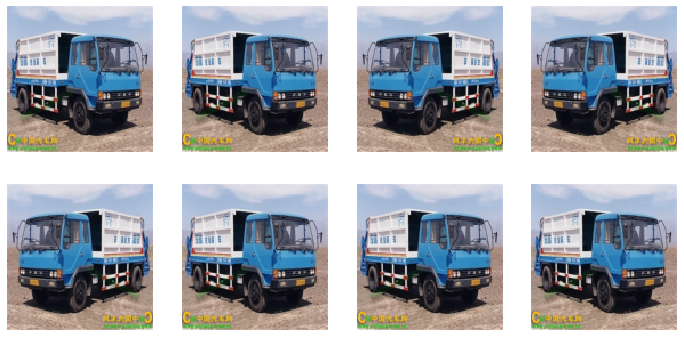

In [29]:
x = next(iter(dl))
print(x.size())
show_batch(x)

We can also make that transform a class so it's easier to set the value of the parameter `p`. As seen before, it also allows us to set the `_order` attribute.

In [30]:
class PilRandomFlip(Transform):
    _order=11
    # p is probability to apply the flip
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

In [31]:
#export
class PilTransform(Transform): _order=11

class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

In [32]:
il1.tfms

[<function exp.nb_08.make_rgb(item)>,
 <function exp.nb_08.to_byte_tensor(item)>,
 <function exp.nb_08.to_float_tensor(item)>,
 <function __main__.pil_random_flip(x)>]

In [33]:
il1.tfms[-1]

<function __main__.pil_random_flip(x)>

In [34]:
# replace pil_random_flip with PilRandomFlip(0.8)
del(il1.tfms[-1])
il1.tfms.append(PilRandomFlip(0.8))

torch.Size([8, 3, 128, 128])


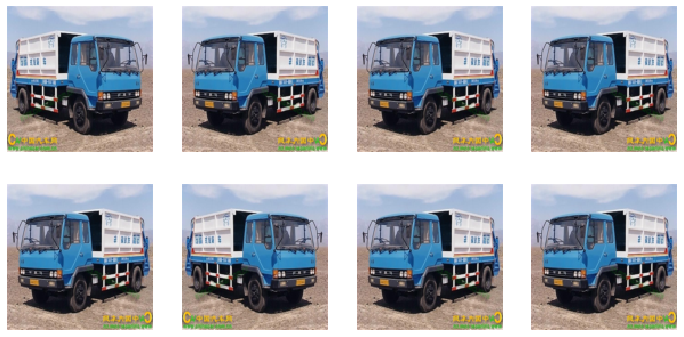

In [35]:
x = next(iter(dl))
print(x.size())
show_batch(x)

### 1B. The Dihedral Group of Transforms
PIL can also do the whole dihedral group of transformations (random horizontal flip, random vertical flip and the four 90 degrees rotation) with the `transpose` method. Here are the codes of the transformations:

NOTE:`transverse` means `transpose` along the 'other' diagonal;

   This is the same as `LR` followed by `transpose` followed by `LR`

FLIP_LEFT_RIGHT = 0

FLIP_TOP_BOTTOM = 1

ROTATE_90 = 2

ROTATE_180 = 3

ROTATE_270 = 4

TRANSPOSE = 5

TRANSVERSE = 6

In [36]:
# PIL.Image??

Be careful that `img.transpose(0)` is already one transform, so doing nothing requires a separate case, then we have 7 different transformations.

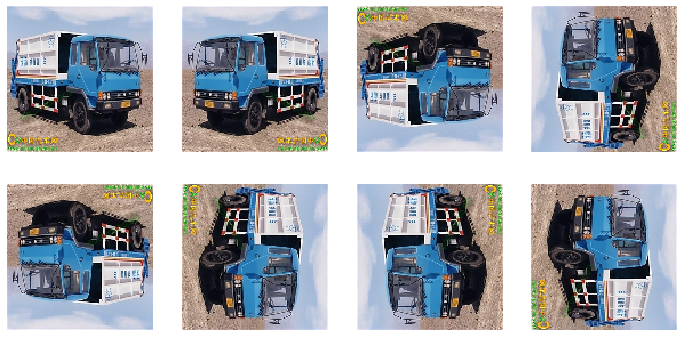

In [37]:
img = PIL.Image.open(il.items[random_index])
img = img.resize((128,128), resample=PIL.Image.NEAREST)
_, axs = plt.subplots(2, 4, figsize=(12, 6))
for i,ax in enumerate(axs.flatten()):
    if i==0: ax.imshow(img)
    else:    ax.imshow(img.transpose(i-1))
    ax.axis('off')

And we can implement it like this:

In [38]:
#export
class PilRandomDihedral(PilTransform):
    # Without the hack, returns the original image with probability of 0.75, 
    #     and one of the 8 transforms with probability of 0.25
    # Q: Why do we need the hack? 
    def __init__(self, p=0.75): self.p=p*7/8 #Little hack to get the 1/8 identity dihedral transform taken into account.
    def __call__(self, x):
        if random.random()>self.p: return x
        return x.transpose(random.randint(0,6))

In [39]:
# replace the last tfm with PilRandomDihedral()
del(il1.tfms[-1])
il1.tfms.append(PilRandomDihedral())

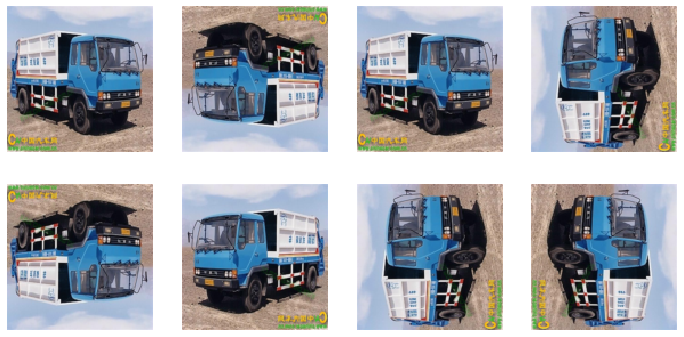

In [40]:
show_batch(next(iter(dl)))

### 1C. Random crop

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=7422)

In [41]:
img = PIL.Image.open(il.items[random_index])
img.size

(640, 457)

To crop an image with PIL we have to specify the top/left and bottom/right corner in this format: (left, top, right, bottom). We won't just crop the size we want, but first crop the section we want of the image and then apply a resize. In what follows, we call the first one the `crop_size`.

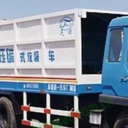

In [42]:
img.crop((60,60,320,320)).resize((128,128), resample=PIL.Image.BILINEAR)

This is pretty fast in PIL:

In [43]:
# top left, bottom right
cnr2 = (60,60,320,320)
# interpolation type
resample = PIL.Image.BILINEAR

In [44]:
%timeit -n 10 img.crop(cnr2).resize((128,128), resample=resample)

367 µs ± 6.79 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Our time budget: aim for 5 mins per batch for imagenet on 8 GPUs. 1.25m images in imagenet. So on one GPU per minute that's `1250000/8/5 == 31250` batches, or 520 batches per second. Assuming 4 cores per GPU, then we want ~125 batches per core per second - so try to stay <10ms per batch. Here we have time to do more things. For instance, we can do the crop and resize in the same call to `transform`, which will give a smoother result.

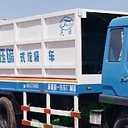

In [45]:
img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

In [46]:
%timeit -n 10 img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

418 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It's a little bit slower but still fast enough for our purpose, so we will use this. We then define a general crop transform and two subclasses: one to crop at the center (for validation) and one to randomly crop. Each time, the subclass only implements the way to get the four corners passed to PIL.

In [47]:
#export
from random import randint

def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz)==2 else [sz[0],sz[0]])

def default_crop_size(w,h): return [w,w] if w < h else [h,h]

class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR): 
        self.resample,self.size = resample,process_sz(size)
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def default_crop_size(self, w,h): return default_crop_size(w,h)

    def __call__(self, x):
        csize = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)
    
    def get_corners(self, w, h): return (0,0,w,h)

class CenterCrop(GeneralCrop):
    # zoom in a bit
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w,h): return [w/self.scale,h/self.scale]
    
    def get_corners(self, w, h, wc, hc):
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

In [48]:
# tfms version 2
il1.tfms = [make_rgb, CenterCrop(128), to_byte_tensor, to_float_tensor]

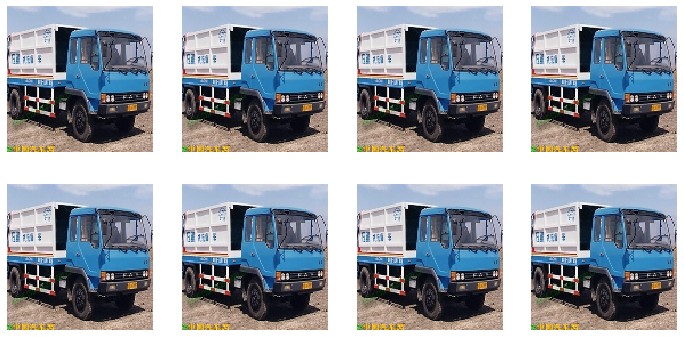

In [49]:
show_batch(next(iter(dl)))

### 1D. RandomResizeCrop

This is the usual data augmentation used on ImageNet (introduced [here](https://arxiv.org/pdf/1409.4842.pdf)) that consists of selecting 8 to 100% of the image area and a scale between 3/4 and 4/3 as a crop, then resizing it to the desired size. It combines some zoom and a bit of squishing at a very low computational cost. This has been very effective in ImageNet competitions. The technique generalizes to other data types as well, such as text sequences.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=7629)

In [50]:
# export
class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale,self.ratio = scale,ratio
    
    def get_corners(self, w, h, wc, hc):
        area = w*h
        #Tries 10 times to get a proper crop inside the image.
        for attempt in range(10):
            # randomly scale the area by a scale randomly chosen on [0.08,1.0]
            area = random.uniform(*self.scale) * area
            # randomly choose a ratio within the interval [3./4., 4./3.]
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            # choose new w and h so as to perserve area 
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top  = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
        
        # Fallback to squish
        if   w/h < self.ratio[0]: size = (w, int(w/self.ratio[0]))
        elif w/h > self.ratio[1]: size = (int(h*self.ratio[1]), h)
        else:                     size = (w, h)
        return ((w-size[0])//2, (h-size[1])//2, (w+size[0])//2, (h+size[1])//2)

In [51]:
# tfms version 3
il1.tfms = [make_rgb, RandomResizedCrop(128), to_byte_tensor, to_float_tensor]

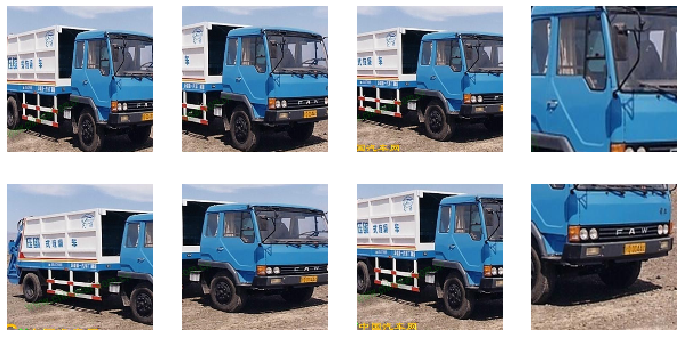

In [52]:
show_batch(next(iter(dl)))

### 1E. Perspective warping 
changing aspect ratio as done in `RandomResizeCrop` is not physically meaningful; better is perspective warping

To do perspective warping, we map the corners of the image to new points: for instance, if we want to tilt the image so that the top looks farther from us, the top/left corner needs to be shifted to the right and the top/right to the left. To avoid squishing, the bottom/left corner needs to be shifted to the left and the bottom/right corner to the right. For instance, if we have an image with corners in:
```
(60,60,60,280,280,280,280,60)
```
(top/left, bottom/left, bottom/right, top/right) then a warped version is:
```
(90,60,30,280,310,280,250,60)
```
PIL can do this for us but it requires 8 coefficients we need to calculate. The math isn't the most important here, as we've done it for you. We need to solve this [equation](https://web.archive.org/web/20150222120106/xenia.media.mit.edu/~cwren/interpolator/). The equation solver is called `torch.solve` in PyTorch.

Q: in the solution presented at the given link, they appear to solve for unknown points X1, Y1, X2, Y2, etc. in terms of the unknown points themselves.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=7751)

In [53]:
# export
from torch import FloatTensor,LongTensor

def find_coeffs(orig_pts, targ_pts):
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8, 1)
    #The 8 scalars we seek are solution of AX = B
    return list(torch.solve(B,A)[0][:,0])

In [54]:
# export
def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w,h = size
    targ_coords = ((0,0),(0,h),(w,h),(w,0))
    c = find_coeffs(src_coords,targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

In [55]:
targ = ((0,0),(0,128),(128,128),(128,0))
src  = ((90,60),(30,280),(310,280),(250,60))

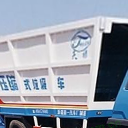

In [56]:
c = find_coeffs(src, targ)
img.transform((128,128), PIL.Image.PERSPECTIVE, list(c), resample=resample)

In [57]:
# bilinear interpolation (default)
%timeit -n 10 warp(img, (128,128), src)

574 µs ± 24.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
# nearest neighbor interpolation
%timeit -n 10 warp(img, (128,128), src, resample=PIL.Image.NEAREST)

201 µs ± 9.93 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
# bicubic interpolation
%timeit -n 10 warp(img, (64,64), src, resample=PIL.Image.BICUBIC)

379 µs ± 9.62 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
# nearest neighbor interpolation
%timeit -n 10 warp(img, (64,64), src, resample=PIL.Image.NEAREST)

118 µs ± 6.46 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [61]:
# export
# return a randomly chosen  point between a and b
def uniform(a,b): return a + (b-a) * random.random()

We can add a transform to do this perspective warping automatically with the rand resize and crop.

In [62]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.NEAREST): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        csize = default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        # randomly choose up-down tilt and left-right tilt
        up_t,lr_t = uniform(-self.magnitude, self.magnitude),uniform(-self.magnitude, self.magnitude)
        left,top = randint(0,x.size[0]-csize[0]),randint(0,x.size[1]-csize[1])
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        # scale and offset
        src_corners = src_corners * tensor(csize).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [63]:
# tfms version 4
il1.tfms = [make_rgb, PilTiltRandomCrop(128, magnitude=0.1), to_byte_tensor, to_float_tensor]

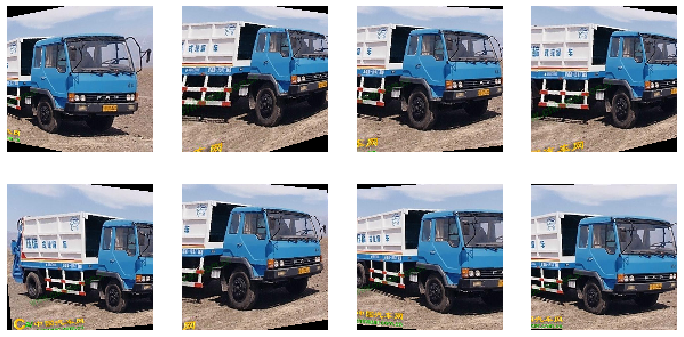

In [64]:
x = next(iter(dl))
show_batch(x)

Problem is that black padding appears as soon as our target points are outside of the image, so we have to limit the magnitude if we want to avoid that.

In [65]:
# export
class PilTiltRandomCrop(PilTransform):
    # BINLINEAR instead of NEAREST
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        csize = default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        left,top = randint(0,x.size[0]-csize[0]),randint(0,x.size[1]-csize[1])
        top_magn = min(self.magnitude, left/csize[0], (x.size[0]-left)/csize[0]-1)
        lr_magn  = min(self.magnitude, top /csize[1], (x.size[1]-top) /csize[1]-1)
        up_t,lr_t = uniform(-top_magn, top_magn),uniform(-lr_magn, lr_magn)
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [66]:
# tfms version 5
# crop_size = 200
il1.tfms = [make_rgb, PilTiltRandomCrop(128, 200, magnitude=0.2), to_byte_tensor, to_float_tensor]

8


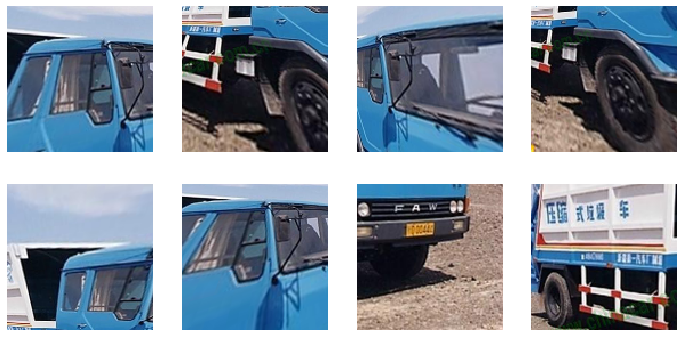

In [67]:
x = next(iter(dl))
print(len(x))
show_batch(x)

## 2. Faster tensor creation

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=7971)

In [68]:
[(o._order,o) for o in sorted(tfms, key=operator.attrgetter('_order'))]

[(0, <function exp.nb_08.make_rgb(item)>),
 (10, <exp.nb_08.ResizeFixed at 0x15fa6452c18>),
 (11, <__main__.PilRandomDihedral at 0x15f9a67d4a8>),
 (20, <function exp.nb_08.to_byte_tensor(item)>),
 (30, <function exp.nb_08.to_float_tensor(item)>)]

In [69]:
#export
import numpy as np

def np_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False)).permute(2,0,1).contiguous()/255.
np_to_float._order = 30

In [71]:
%timeit -n 10 np_to_float(img)

4.19 ms ± 81.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It is actually faster to combine `to_float_tensor` and `to_byte_tensor` in one transform using numpy.

In [70]:
%timeit -n 10 to_float_tensor(to_byte_tensor(img))

1.49 ms ± 29.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 3. Batch-wise data augmentation on the GPU

You can write your own augmentation for your domain's data types, and have them run on the GPU, by using regular PyTorch tensor operations. Here's an example for images. The key is to do them on a whole batch at a time. Nearly all PyTorch operations can be done batch-wise.

Once we have resized our images so that we can batch them together, we can apply more data augmentation on a batch level. For the affine/coord transforms, we proceed like this:
1. generate a grid map of the size of our batch (bs x height x width x 2) that contains the coordinates of a grid of size height x width (this will be the final size of the image, and doesn't have to be the same as the current size in the batch)
2. apply the affine transforms (which is a matrix multiplication) and the coord transforms to that grid map
3. interpolate the values of the final pixels we want from the initial images in the batch, according to the transformed grid map

For 1. and 3. there are PyTorch functions: `F.affine_grid` and `F.grid_sample`. `F.affine_grid` can even combine 1 and 2 if we just want to do an affine transformation.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=8029)

### Step 1: generate the grid

In [72]:
# tfms version 6
il1.tfms = [make_rgb, PilTiltRandomCrop(128, magnitude=0.2), to_byte_tensor, to_float_tensor]

In [73]:
# batch size 64
dl = DataLoader(il1, 64)

In [74]:
x = next(iter(dl))
print(x.size())

torch.Size([64, 3, 128, 128])


In [75]:
from torch import FloatTensor

In [76]:
def affine_grid_cpu(size):
    N, C, H, W = size
    grid = FloatTensor(N, H, W, 2)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else tensor([-1])
    grid[:, :, :, 0] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, :, 0])
    linear_points = torch.linspace(-1, 1, H) if H > 1 else tensor([-1])
    grid[:, :, :, 1] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, :, 1])
    return grid

In [77]:
grid = affine_grid_cpu(x.size())

In [78]:
grid.shape

torch.Size([64, 128, 128, 2])

In [79]:
grid[0,:5,:5]

tensor([[[-1.0000, -1.0000],
         [-0.9843, -1.0000],
         [-0.9685, -1.0000],
         [-0.9528, -1.0000],
         [-0.9370, -1.0000]],

        [[-1.0000, -0.9843],
         [-0.9843, -0.9843],
         [-0.9685, -0.9843],
         [-0.9528, -0.9843],
         [-0.9370, -0.9843]],

        [[-1.0000, -0.9685],
         [-0.9843, -0.9685],
         [-0.9685, -0.9685],
         [-0.9528, -0.9685],
         [-0.9370, -0.9685]],

        [[-1.0000, -0.9528],
         [-0.9843, -0.9528],
         [-0.9685, -0.9528],
         [-0.9528, -0.9528],
         [-0.9370, -0.9528]],

        [[-1.0000, -0.9370],
         [-0.9843, -0.9370],
         [-0.9685, -0.9370],
         [-0.9528, -0.9370],
         [-0.9370, -0.9370]]])

In [80]:
%timeit -n 10 grid = affine_grid_cpu(x.size())

2.96 ms ± 25.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Coords in the grid go from -1, to 1 (PyTorch convention).

PyTorch version is slower on the CPU but optimized to go very fast on the GPU

In [81]:
m = tensor([[1., 0., 0.], [0., 1., 0.]])
theta = m.expand(x.size(0), 2, 3)

In [82]:
theta.shape

torch.Size([64, 2, 3])

In [83]:
%timeit -n 10 grid = F.affine_grid(theta, x.size())

8.6 ms ± 66.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [84]:
%timeit -n 10 grid = F.affine_grid(theta.cuda(), x.size())

The slowest run took 887.28 times longer than the fastest. This could mean that an intermediate result is being cached.
20.2 ms ± 49.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So we write our own version that dispatches on the CPU with our function and uses PyTorch's on the GPU.

In [85]:
def affine_grid(x, size):
    size = (size,size) if isinstance(size, int) else tuple(size)
    size = (x.size(0),x.size(1)) + size
    if x.device.type == 'cpu': return affine_grid_cpu(size) 
    m = tensor([[1., 0., 0.], [0., 1., 0.]], device=x.device)
    return F.affine_grid(m.expand(x.size(0), 2, 3), size)

In [86]:
grid = affine_grid(x, 128)

### Step 2: Affine multiplication

In 2D an affine transformation has the form y = Ax + b where A is a 2x2 matrix and b a vector with 2 coordinates. It's usually represented by the 3x3 matrix
```
A[0,0]  A[0,1]  b[0]
A[1,0]  A[1,1]  b[1]
   0       0     1
```
because then the composition of two affine transforms can be computed with the matrix product of their 3x3 representations.

In [87]:
from torch import stack,zeros_like,ones_like

The matrix for a rotation that has an angle of `theta` is:
```
cos(theta) -sin(theta) 0
sin(theta)  cos(theta) 0
0           0          1
```
Here we have to apply the reciprocal of a regular rotation (exercise: find why!) so we use this matrix:
```
 cos(theta) sin(theta) 0
-sin(theta) cos(theta) 0
 0          0          1
```
then we draw a different `theta` for each version of the image in the batch to return a batch of rotation matrices (size `bs x 3 x 3`).

In [88]:
def rotation_matrix(thetas):
    thetas.mul_(math.pi/180)
    rows = [stack([thetas.cos(),             thetas.sin(),             torch.zeros_like(thetas)], dim=1),
            stack([-thetas.sin(),            thetas.cos(),             torch.zeros_like(thetas)], dim=1),
            stack([torch.zeros_like(thetas), torch.zeros_like(thetas), torch.ones_like(thetas)], dim=1)]
    return stack(rows, dim=1)

In [89]:
thetas = torch.empty(x.size(0)).uniform_(-30,30)
print(thetas.size())

torch.Size([64])


In [90]:
thetas[:5]

tensor([  0.3859, -26.0312,  15.4584, -19.9736, -12.3230])

In [91]:
m = rotation_matrix(thetas)

In [92]:
m.shape, m[:,None].shape, grid.shape

(torch.Size([64, 3, 3]),
 torch.Size([64, 1, 3, 3]),
 torch.Size([64, 128, 128, 2]))

In [93]:
grid.view(64,-1,2).shape

torch.Size([64, 16384, 2])

We have to apply our rotation to every point in the grid. The matrix a is given by the first two rows and two columns of `m` and the vector `b` is the first two coefficients of the last column. Of course we have to deal with the fact that here `m` is  a batch of matrices.

In [94]:
a = m[:,:2,:2]
print(a.shape)
b = m[:, 2:,:2]
print(b.shape)
tfm_grid = (grid.view(64,-1,2) @ a + b).view(64, 128, 128, 2)
print(tfm_grid.shape)

torch.Size([64, 2, 2])
torch.Size([64, 1, 2])
torch.Size([64, 128, 128, 2])


We can also do this without the `view` by using broadcasting. 

In [95]:
%timeit -n 10 tfm_grid = grid @ m[:,None,:2,:2] + m[:,2,:2][:,None,None]

10.4 ms ± 56.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [96]:
%timeit -n 10 tfm_grid = torch.einsum('bijk,bkl->bijl', grid, m[:,:2,:2]) + m[:,2,:2][:,None,None]

9.88 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [97]:
%timeit -n 10 tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2][:,None,None]

10.6 ms ± 54.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [98]:
%timeit -n 10 tfm_grid = (torch.bmm(grid.view(64,-1,2), m[:,:2,:2]) + m[:,2,:2][:,None]).view(-1, 128, 128, 2)

9.79 ms ± 57.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


And on the GPU

In [99]:
grid = grid.cuda()
m = m.cuda()

In [100]:
%timeit -n 10 tfm_grid = grid @ m[:,None,:2,:2] + m[:,2,:2][:,None,None]

The slowest run took 119.89 times longer than the fastest. This could mean that an intermediate result is being cached.
4.87 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [101]:
%timeit -n 10 tfm_grid = torch.einsum('bijk,bkl->bijl', grid, m[:,:2,:2]) + m[:,2,:2][:,None,None]

271 µs ± 7.15 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [102]:
%timeit -n 10 tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2][:,None,None]

300 µs ± 3.21 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [103]:
%timeit -n 10 tfm_grid = (torch.bmm(grid.view(64,-1,2), m[:,:2,:2]) + m[:,2,:2][:,None]).view(-1, 128, 128, 2)

181 µs ± 8.03 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Step 3: interpolate

Since `bmm` (batch matrix matrix multiplication) is always the fastest, we use this one for the matrix multiplication.

In [104]:
tfm_grid = torch.bmm(grid.view(64,-1,2), m[:,:2,:2]).view(-1, 128, 128, 2)

The interpolation to find our coordinates back is done by `grid_sample`.

In [105]:
tfm_x = F.grid_sample(x, tfm_grid.cpu())

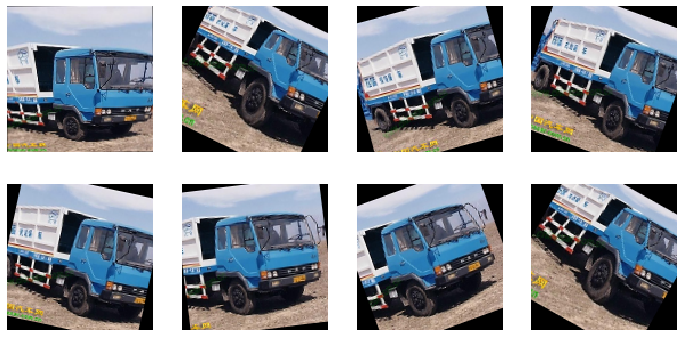

In [106]:
show_batch(tfm_x, r=2)

It takes a `padding_mode` argument.

In [107]:
tfm_x = F.grid_sample(x, tfm_grid.cpu(), padding_mode='reflection')

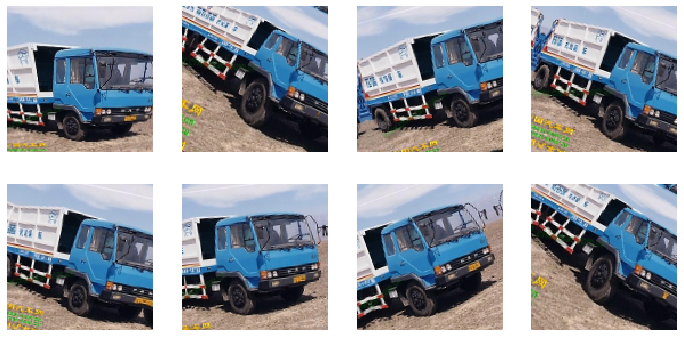

In [108]:
show_batch(tfm_x, r=2)

## 4. Timing

Let's look at the speed now!

In [109]:
def rotate_batch(x, size, degrees):
    grid = affine_grid(x, size)
    thetas = x.new(x.size(0)).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    tfm_grid = grid @ m[:,:2,:2].unsqueeze(1) + m[:,2,:2][:,None,None]
    return F.grid_sample(x, tfm_grid)

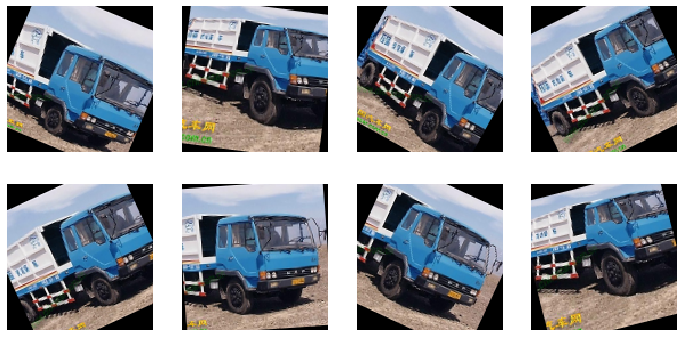

In [110]:
show_batch(rotate_batch(x, 128, 30), r=2)

In [111]:
%timeit -n 10 tfm_x = rotate_batch(x, 128, 30)

35.3 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [112]:
# GPU cuts time by a factor of 7
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

4.81 ms ± 265 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [121]:
# Jeremy got a factor of 17 speedup
45.6/2.65

17.20754716981132

In [123]:
# I got a smaller (factor of 7) speedup from the GPU
#      and my final speed is 4.8 ms compared to Jeremy's 2.6 ms
35.3/4.81

7.338877338877339

Not bad for 64 rotations! Takes about 5 ms per batch, well under the 10 ms that we have allotted for batch augmentation.

### 4A. JIT version

But we can be even faster!

### Note: I've not yet understood why attempting to use the JIT compiler throws a `RuntimeError` 

In [113]:
from torch import Tensor

In [114]:
from torch.jit import script

@script
def rotate_batch(x:Tensor, size:int, degrees:float) -> Tensor:
    sz = (x.size(0),x.size(1)) + (size,size)
    idm = torch.zeros(2,3, device=x.device)
    idm[0,0] = 1.
    idm[1,1] = 1.
    grid = F.affine_grid(idm.expand(x.size(0), 2, 3), sz)
    thetas = torch.zeros(x.size(0), device=x.device).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2].unsqueeze(1).unsqueeze(2)
    return F.grid_sample(x, tfm_grid)

RuntimeError: 
Arguments for call are not valid.
The following operator variants are available:
  
  aten::div(Tensor self, Tensor other, *, Tensor(a) out) -> (Tensor(a)):
  Expected a value of type 'Tensor' for argument 'self' but instead found type 'float'.
  
  aten::div(Tensor self, Tensor other) -> (Tensor):
  Expected a value of type 'Tensor' for argument 'self' but instead found type 'float'.
  
  aten::div(Tensor self, Scalar other) -> (Tensor):
  Expected a value of type 'Tensor' for argument 'self' but instead found type 'float'.
  
  aten::div(int a, int b) -> (float):
  Expected a value of type 'int' for argument 'a' but instead found type 'float'.
  
  aten::div(float a, float b) -> (float):
  Expected a value of type 'float' for argument 'b' but instead found type 'int'.
  
  div(float a, Tensor b) -> (Tensor):
  Expected a value of type 'Tensor' for argument 'b' but instead found type 'int'.
  
  div(int a, Tensor b) -> (Tensor):
  Expected a value of type 'int' for argument 'a' but instead found type 'float'.

The original call is:
at <ipython-input-88-3b549180ff18>:2:17
def rotation_matrix(thetas):
    thetas.mul_(math.pi/180)
                ~~~~~~~~~~~ <--- HERE
    rows = [stack([thetas.cos(),             thetas.sin(),             torch.zeros_like(thetas)], dim=1),
            stack([-thetas.sin(),            thetas.cos(),             torch.zeros_like(thetas)], dim=1),
            stack([torch.zeros_like(thetas), torch.zeros_like(thetas), torch.ones_like(thetas)], dim=1)]
    return stack(rows, dim=1)
'rotation_matrix' is being compiled since it was called from 'rotate_batch'
at <ipython-input-114-0099615243cb>:11:5
@script
def rotate_batch(x:Tensor, size:int, degrees:float) -> Tensor:
    sz = (x.size(0),x.size(1)) + (size,size)
    idm = torch.zeros(2,3, device=x.device)
    idm[0,0] = 1.
    idm[1,1] = 1.
    grid = F.affine_grid(idm.expand(x.size(0), 2, 3), sz)
    thetas = torch.zeros(x.size(0), device=x.device).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    ~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2].unsqueeze(1).unsqueeze(2)
    return F.grid_sample(x, tfm_grid)


In [115]:
m = tensor([[1., 0., 0.], [0., 1., 0.]], device=x.device)

In [116]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

4.74 ms ± 654 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [117]:
tfm_x

tensor([[[[0.8197, 0.8298, 0.8331,  ..., 0.9053, 0.9036, 0.9028],
          [0.8138, 0.8240, 0.8280,  ..., 0.8787, 0.8738, 0.8730],
          [0.7880, 0.7997, 0.8065,  ..., 0.8740, 0.8700, 0.8700],
          ...,
          [0.3567, 0.3494, 0.4502,  ..., 0.6776, 0.7484, 0.8133],
          [0.3902, 0.3818, 0.3402,  ..., 0.8049, 0.7968, 0.7544],
          [0.7574, 0.7510, 0.6359,  ..., 0.8313, 0.8101, 0.7664]],

         [[0.8340, 0.8408, 0.8406,  ..., 0.9013, 0.8997, 0.8989],
          [0.8275, 0.8348, 0.8351,  ..., 0.8747, 0.8699, 0.8691],
          [0.7998, 0.8098, 0.8117,  ..., 0.8700, 0.8661, 0.8661],
          ...,
          [0.5607, 0.5661, 0.6376,  ..., 0.5698, 0.6402, 0.7044],
          [0.6013, 0.6072, 0.6645,  ..., 0.6945, 0.6854, 0.6446],
          [0.7522, 0.7462, 0.6900,  ..., 0.7209, 0.6986, 0.6566]],

         [[0.9062, 0.9094, 0.9043,  ..., 0.9249, 0.9232, 0.9224],
          [0.8988, 0.9024, 0.8975,  ..., 0.8983, 0.8934, 0.8926],
          [0.8630, 0.8694, 0.8672,  ..., 0

The speed of this depends a lot on what card you have. On a V100 it is generally about 3x faster than non-JIT (as at April 2019) although PyTorch JIT is rapidly improving.

### 4B. affine multiplication with `affine_grid`

And even faster if we give the matrix rotation to `affine_grid`.

In [118]:
def rotate_batch(x, size, degrees):
    size = (size,size) if isinstance(size, int) else tuple(size)
    size = (x.size(0),x.size(1)) + size
    thetas = x.new(x.size(0)).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    grid = F.affine_grid(m[:,:2], size)
    return F.grid_sample(x.cuda(), grid)

In [119]:
# roughly 25% speedup from JIT, comparable to what Jeremy saw
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

3.21 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Export

In [120]:
# !./notebook2script.py 10_augmentation.ipynb
!python notebook2script.py 10_augmentation.ipynb

Converted 10_augmentation.ipynb to exp\nb_10.py
